# Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline
import xgboost as xgb
import lib.DB_lib as dl
import lib.Plot_lib as pl
import lib.Data_lib as dtl
import lib.VAE_lib
import talib as tb
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from joblib import dump, load
import Constants

# Constants

In [2]:
mills_for_1min = Constants.mills_for_1min
sample_rate_1h = Constants.sample_rate_1h
total_time_steps = Constants.train_total_time_steps
no_of_points = Constants.train_no_of_points
symbol = 'ethusdt'
interval = '15m'
vae_model_path = '../VAE_model/vae_model_ethusdt.pth'
pre_processed = '../pre_processed/ethusdt.csv'
min_max_scaler = '../scalar/min_max_scalar_ethusdt.pkl'
standard_scaler = '../scalar/standard_scalar_ethusdt.pkl'


# Data Import

In [3]:
dataset_ex_df=dl.get_dataset_for_time_period(symbol, interval, total_time_steps)    
dataset_ex_df['closet_time'] = pd.to_datetime(dataset_ex_df['closet_time'], unit='ms')
dataset_ex_df

,start_time,closet_time,open,close,high,low,volume,no_of_trades,quote_taker_ast_vol,buy_base_ast_vol,taker_buy_quote_ast_vol
0,1714912200000,2024-05-05 12:44:59.999,3134.51000000,3138.79000000,3138.80000000,3130.64000000,1226.15700000,4640,3844178.42188700,635.15660000,1991155.84692700
1,1714911300000,2024-05-05 12:29:59.999,3133.40000000,3134.52000000,3137.72000000,3129.43000000,979.65670000,3703,3069081.02854300,482.58980000,1512137.30065600
2,1714910400000,2024-05-05 12:14:59.999,3138.10000000,3133.40000000,3141.04000000,3133.40000000,873.65200000,4560,2740797.58527500,412.20080000,1293327.83105200
3,1714909500000,2024-05-05 11:59:59.999,3138.60000000,3138.10000000,3141.14000000,3132.20000000,874.98020000,3857,2744358.03241100,442.11880000,1386618.05243100
4,1714908600000,2024-05-05 11:44:59.999,3139.04000000,3138.59000000,3140.16000000,3135.20000000,771.24940000,3980,2419899.04266800,398.96290000,1251846.90746400
...,...,...,...,...,...,...,...,...,...,...,...
79996,1642911300000,2022-01-23 04:29:59.999,2429.56000000,2434.19000000,2437.00000000,2423.59000000,5532.37860000,11292,13443844.05263400,2886.28360000,7015463.79079900
79997,1642910400000,2022-01-23 04:14:59.999,2416.68000000,2429.55000000,2433.26000000,2407.08000000,5609.42120000,14189,13566627.06934700,2318.05600000,5608469.54320800
79998,1642909500000,2022-01-23 03:59:59.999,2415.87000000,2416.68000000,2420.40000000,2411.49000000,2005.98940000,4605,4846700.30661400,1001.77930000,2420411.50782600
79999,1642908600000,2022-01-23 03:44:59.999,2397.52000000,2415.87000000,2419.37000000,2394.16000000,2743.47890000,6079,6605605.63537900,1551.96170000,3736390.85184100


# Create upper level time frame data

In [4]:
df = pd.DataFrame()
for i in range(no_of_points):
    ending_point = i * sample_rate_1h
    starting_point = (i + 1) * sample_rate_1h - 1
    closet_time = dataset_ex_df.loc[ending_point, 'closet_time']
    open_price = dataset_ex_df.loc[starting_point, 'open']
    close_price = dataset_ex_df.loc[ending_point, 'close']
    high_price = dataset_ex_df.loc[ending_point:starting_point, 'high'].max()
    low_price = dataset_ex_df.loc[ending_point:starting_point, 'low'].max()
    volume = dataset_ex_df.loc[ending_point:starting_point, 'volume'].sum()
    no_of_trades = dataset_ex_df.loc[ending_point:starting_point, 'no_of_trades'].sum()
    quote_taker_ast_vol = dataset_ex_df.loc[ending_point:starting_point, 'quote_taker_ast_vol'].sum()
    buy_base_ast_vol = dataset_ex_df.loc[ending_point:starting_point, 'buy_base_ast_vol'].sum()
    taker_buy_quote_ast_vol = dataset_ex_df.loc[ending_point:starting_point, 'taker_buy_quote_ast_vol'].sum()
    df = df._append({'closet_time': closet_time,
                     'open': open_price,
                     'close': close_price,
                     'high': high_price,
                     'low': low_price,
                     'volume': volume,
                     'no_of_trades': no_of_trades,
                     'quote_taker_ast_vol': quote_taker_ast_vol,
                     'buy_base_ast_vol': buy_base_ast_vol,
                     'taker_buy_quote_ast_vol': taker_buy_quote_ast_vol}, ignore_index=True)

# Data Visualization & Preprocess

In [5]:
df_reverse = df.iloc[::-1]
df_reverse.reset_index(drop=True, inplace=True)
dataset_ex_df = df_reverse
dataset_ex_df

,closet_time,open,close,high,low,volume,no_of_trades,quote_taker_ast_vol,buy_base_ast_vol,taker_buy_quote_ast_vol
0,2022-01-23 07:29:59.999,2397.52000000,2493.78000000,2498.00000000,2483.18000000,101924.82570000,167355,249671047.49235100,52319.98470000,128290149.19933800
1,2022-01-23 11:29:59.999,2493.78000000,2510.04000000,2556.78000000,2528.41000000,117886.89700000,227985,296477942.24938700,58817.62300000,147903786.07868300
2,2022-01-23 15:29:59.999,2510.04000000,2433.44000000,2518.27000000,2496.98000000,98780.91290000,203357,243889334.00967200,47916.89130000,118416327.51913800
3,2022-01-23 19:29:59.999,2433.20000000,2425.10000000,2454.44000000,2435.79000000,56573.97370000,112533,137371017.75531900,29539.54440000,71738874.83061200
4,2022-01-23 23:29:59.999,2425.10000000,2531.78000000,2547.65000000,2515.24000000,124656.47560000,193150,306806138.41721000,72775.49170000,179551869.63439100
...,...,...,...,...,...,...,...,...,...,...
4995,2024-05-04 20:44:59.999,3125.28000000,3133.16000000,3147.00000000,3138.65000000,23928.13560000,82272,74877238.55753100,13042.44310000,40822018.26429600
4996,2024-05-05 00:44:59.999,3133.16000000,3094.93000000,3135.11000000,3127.63000000,33073.63300000,85133,102900289.43169300,16459.56930000,51214636.87590100
4997,2024-05-05 04:44:59.999,3094.93000000,3091.41000000,3113.94000000,3098.78000000,39958.71460000,108268,123412071.63244500,20773.41640000,64163932.31684100
4998,2024-05-05 08:44:59.999,3091.41000000,3146.38000000,3150.61000000,3119.05000000,38055.81470000,94695,118610028.48564300,23844.23490000,74386544.71395600


#### Add Log change and Percentage change of the Close price

In [6]:
dataset_ex_df['pct_change'] = (dataset_ex_df['close'] - dataset_ex_df['close'].shift(1))/ dataset_ex_df['close'].shift(1)
dataset_ex_df['log_change'] = np.log((dataset_ex_df['close']/ dataset_ex_df['close'].shift(1)).astype(float))
dataset_ex_df['prev_close'] = dataset_ex_df['close'].shift(2)
dataset_ex_df = dataset_ex_df.dropna()
print('{} number of entries & {} of features in the dataset.'.format(dataset_ex_df.shape[0],dataset_ex_df.shape[1]))
dataset_ex_df

4998 number of entries & 13 of features in the dataset.


C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_27096\3966083660.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_ex_df['pct_change'] = (dataset_ex_df['close'] - dataset_ex_df['close'].shift(1))/ dataset_ex_df['close'].shift(1)
C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_27096\3966083660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_ex_df['log_change'] = np.log((dataset_ex_df['close']/ dataset_ex_df['close'].shift(1)).astype(float))
C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_2

,closet_time,open,close,high,low,volume,no_of_trades,quote_taker_ast_vol,buy_base_ast_vol,taker_buy_quote_ast_vol,pct_change,log_change,prev_close
2,2022-01-23 15:29:59.999,2510.04000000,2433.44000000,2518.27000000,2496.98000000,98780.91290000,203357,243889334.00967200,47916.89130000,118416327.51913800,-0.03051744195311628499944223996,-0.030993,2493.78000000
3,2022-01-23 19:29:59.999,2433.20000000,2425.10000000,2454.44000000,2435.79000000,56573.97370000,112533,137371017.75531900,29539.54440000,71738874.83061200,-0.003427247024787954500624630153,-0.003433,2510.04000000
4,2022-01-23 23:29:59.999,2425.10000000,2531.78000000,2547.65000000,2515.24000000,124656.47560000,193150,306806138.41721000,72775.49170000,179551869.63439100,0.04398993855923467073522741330,0.043050,2433.44000000
5,2022-01-24 03:29:59.999,2531.79000000,2449.64000000,2543.73000000,2528.10000000,91527.24350000,166817,227717122.94888800,45195.92770000,112519155.75314300,-0.03244357724604823483873006343,-0.032982,2425.10000000
6,2022-01-24 07:29:59.999,2449.78000000,2416.65000000,2471.38000000,2456.32000000,52186.10050000,113631,127229045.25690800,25553.87800000,62318639.50238500,-0.01346728498881468297382472527,-0.013559,2531.78000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2024-05-04 20:44:59.999,3125.28000000,3133.16000000,3147.00000000,3138.65000000,23928.13560000,82272,74877238.55753100,13042.44310000,40822018.26429600,0.002521374084881994573286233553,0.002518,3145.47000000
4996,2024-05-05 00:44:59.999,3133.16000000,3094.93000000,3135.11000000,3127.63000000,33073.63300000,85133,102900289.43169300,16459.56930000,51214636.87590100,-0.01220173881959427542800240013,-0.012277,3125.28000000
4997,2024-05-05 04:44:59.999,3094.93000000,3091.41000000,3113.94000000,3098.78000000,39958.71460000,108268,123412071.63244500,20773.41640000,64163932.31684100,-0.001137343978700649126151480001,-0.001138,3133.16000000
4998,2024-05-05 08:44:59.999,3091.41000000,3146.38000000,3150.61000000,3119.05000000,38055.81470000,94695,118610028.48564300,23844.23490000,74386544.71395600,0.01778153011085556428943427109,0.017625,3094.93000000


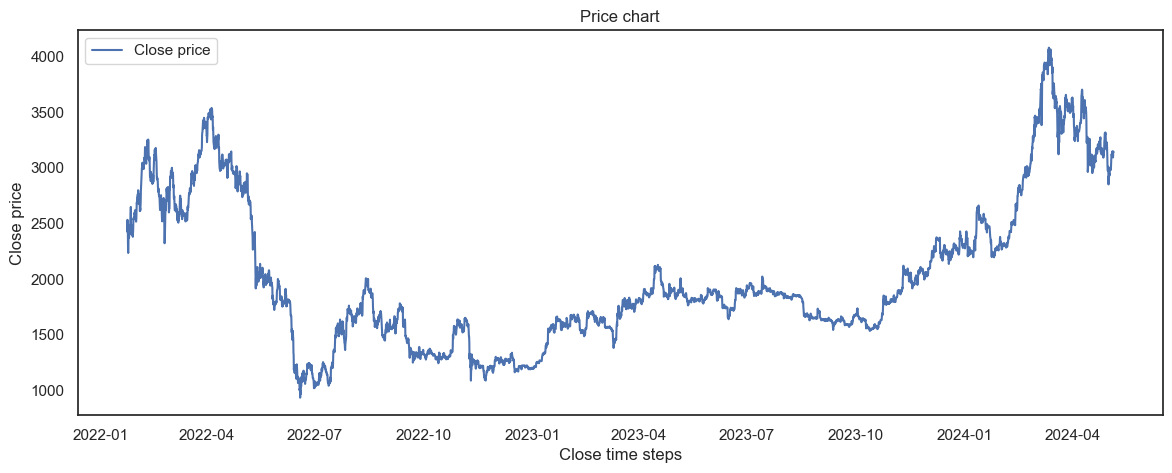

In [7]:
pl.plot_dataset(dataset_ex_df, "closet_time", "Close time steps", "close", "Close price", "Close price", "Price chart")

## Create Indicators

Simple Moving Average : 
*   SMA3 - 15m
*   SMA12 - 1h
*   SMA20 - 100m
*   SMA48 - 4h
*   SMA50 - 250m
*   SMA288 - 1d

Exponential Moving Average
*   EMA12 - 1h
*   EMA20 - 100m
*   EMA26 - 130m

Moving Average Convergence/Divergence
*   MACD12 - 1h
*   MACD24 - 2h

Relative Strength Index
*   RSI12 - 1h
*   RSI24 - 2h
*   RSI36 - 3h

Average True Range
*   ATR12 - 1h
*   ATR24 - 2h
*   ATR36 - 3h

Bollinger Bands
*   UpperBand12,LowerBand12  - 1h
*   UpperBand24,LowerBand24 - 2h
*   UpperBand36,LowerBand36 - 3h

MOM
*   MoM10

OBV
*   OBV

https://mrjbq7.github.io/ta-lib/

https://www.forex.in.rs/moving-average-for-5-min-chart/#:~:text=The%20best%20moving%20averages%20for,20%20MA%20and%2050%20MA.

In [8]:
dataset_Idc = dtl.CreateInc(dataset_ex_df,"close","high","low","volume")
dataset_Idc

,closet_time,open,close,high,low,volume,no_of_trades,quote_taker_ast_vol,buy_base_ast_vol,taker_buy_quote_ast_vol,...,ATR24,ATR36,Upperband12,Lowerband12,Upperband24,Lowerband24,Upperband36,Lowerband36,MOM10,OBV
0,2022-03-12 11:29:59.999,2587.92000000,2583.87000000,2593.00000000,2584.85000000,25362.33390000,46613,65555412.90860700,12425.70050000,32121568.79449700,...,32.975578,35.222346,2634.132841,2544.182159,2744.790219,2499.363948,2727.254672,2472.348662,-20.88,7.172771e+04
1,2022-03-12 15:29:59.999,2583.88000000,2573.98000000,2596.35000000,2590.00000000,38033.65230000,58494,98160832.47010800,17858.33700000,46098753.65204000,...,32.121596,34.590614,2632.013828,2541.819505,2744.207806,2501.308861,2726.049013,2470.980431,-39.83,3.369406e+04
2,2022-03-12 19:29:59.999,2573.98000000,2582.86000000,2616.79000000,2595.07000000,73149.38920000,79706,189799444.04963100,41060.95310000,106561187.50724600,...,32.566946,34.818930,2628.909390,2541.275610,2744.011044,2502.317290,2724.642873,2470.029349,45.19,1.068434e+05
3,2022-03-12 23:29:59.999,2582.86000000,2588.71000000,2592.77000000,2589.45000000,16853.64670000,34800,43582050.13996000,8621.09960000,22293380.78713200,...,31.622906,34.127016,2623.397410,2542.604256,2743.945678,2502.905156,2724.682743,2472.367257,-22.37,1.236971e+05
4,2022-03-13 03:29:59.999,2588.94000000,2590.42000000,2603.32000000,2590.47000000,40803.59010000,59375,105402762.55653800,20502.46410000,52988031.90120600,...,30.914035,33.584876,2617.195602,2557.597731,2740.460240,2500.359760,2724.062605,2476.635729,-26.14,1.645007e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,2024-05-04 20:44:59.999,3125.28000000,3133.16000000,3147.00000000,3138.65000000,23928.13560000,82272,74877238.55753100,13042.44310000,40822018.26429600,...,32.066166,32.272169,3196.128702,2959.266298,3180.191014,2847.208152,3263.063048,2845.273618,131.98,-6.117590e+06
4707,2024-05-05 00:44:59.999,3133.16000000,3094.93000000,3135.11000000,3127.63000000,33073.63300000,85133,102900289.43169300,16459.56930000,51214636.87590100,...,31.041742,31.583498,3190.750482,2983.391184,3187.073635,2848.019698,3244.542620,2853.671268,114.24,-6.150663e+06
4708,2024-05-05 04:44:59.999,3094.93000000,3091.41000000,3113.94000000,3098.78000000,39958.71460000,108268,123412071.63244500,20773.41640000,64163932.31684100,...,30.540420,31.234234,3184.426050,3004.753950,3193.001675,2848.974991,3235.029712,2856.991399,62.41,-6.190622e+06
4709,2024-05-05 08:44:59.999,3091.41000000,3146.38000000,3150.61000000,3119.05000000,38055.81470000,94695,118610028.48564300,23844.23490000,74386544.71395600,...,31.734569,32.011061,3170.667817,3046.127183,3196.763893,2869.942774,3232.620951,2857.987937,67.98,-6.152566e+06


In [9]:
dtl.NaNCheck(dataset_Idc)

Series([], dtype: int64)

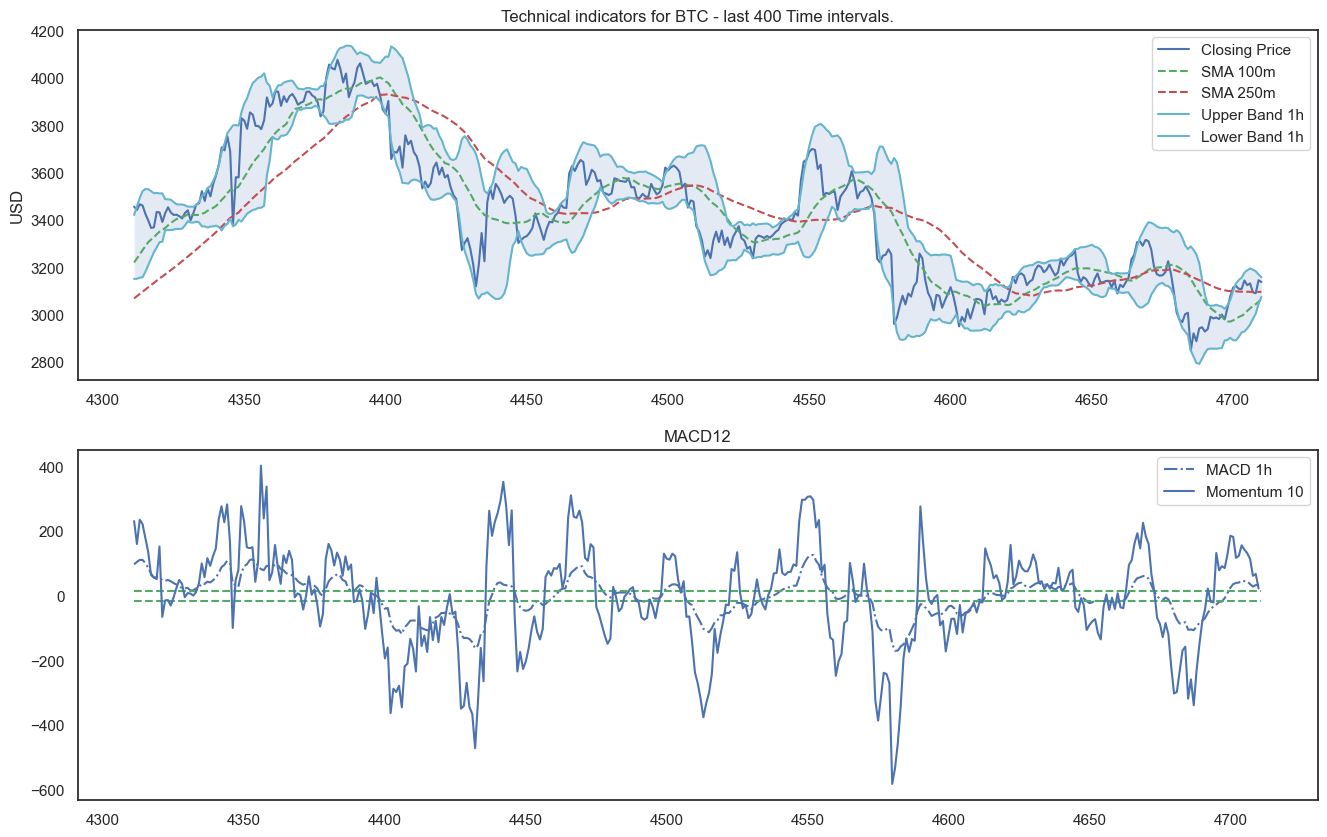

In [10]:
pl.plot_technical_indicators(dataset_Idc,400)

In [11]:
dataset_Idc.columns

Index(['closet_time', 'open', 'close', 'high', 'low', 'volume', 'no_of_trades',
       'quote_taker_ast_vol', 'buy_base_ast_vol', 'taker_buy_quote_ast_vol',
       'pct_change', 'log_change', 'prev_close', 'SMA3', 'SMA12', 'SMA20',
       'SMA48', 'SMA50', 'SMA288', 'EMA12', 'EMA20', 'EMA26', 'MACD12',
       'MACD24', 'RSI12', 'RSI24', 'RSI36', 'ATR12', 'ATR24', 'ATR36',
       'Upperband12', 'Lowerband12', 'Upperband24', 'Lowerband24',
       'Upperband36', 'Lowerband36', 'MOM10', 'OBV'],
      dtype='object')

# Extract Multi frequency trends

#### Create Fourier Transformed values for Close price

In [12]:
close_fft = np.fft.fft(np.asarray(dataset_Idc['close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
output_df_fft = fft_df.copy()

Do Inverse Fourier Transformation and extract Multi-Frequency trading patterns

C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_27096\2767890319.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
D:\envs\crypto\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_27096\2767890319.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
D:\envs\crypto\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\KAVISHKA\AppData\Local\Temp\ipykernel_27096\2767890319.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  output_df_fft[f'FT_{num_}components'] = np.fft.if

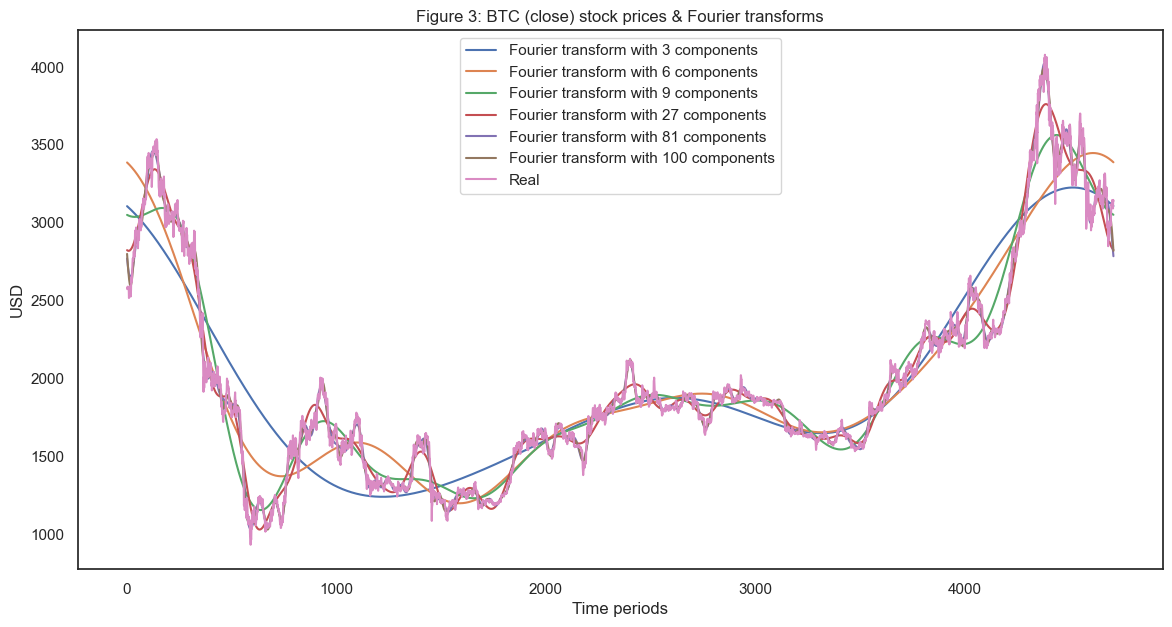

In [13]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 27, 81, 100]:
    fft_list_m10= np.copy(fft_list) 
    fft_list_m10[num_:-num_]=0
    output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(dataset_Idc['close'],  label='Real')
plt.xlabel('Time periods')
plt.ylabel('USD')
plt.title('Figure 3: BTC (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [14]:
print(output_df_fft.shape)
output_df_fft

(4711, 9)


,fft,absolute,angle,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
0,9.309725e+06+6.884875e-10j,9.309725e+06,7.395358e-17,3106.313417,3386.636669,3050.420725,2824.129722,2770.831344,2800.021358
1,1.355051e+06+8.028065e+05j,1.575011e+06,5.348532e-01,3105.105721,3385.372965,3049.703357,2823.024097,2756.934575,2780.378140
2,1.139958e+06+3.354235e+05j,1.188282e+06,2.861659e-01,3103.892432,3384.095923,3049.007544,2822.075848,2743.642234,2760.969431
3,3.341006e+05+4.362130e+05j,5.494588e+05,9.171894e-01,3102.673560,3382.805541,3048.333231,2821.286110,2731.017582,2741.955976
4,3.484233e+05+8.033502e+04j,3.575647e+05,2.266071e-01,3101.449115,3381.501817,3047.680361,2820.655914,2719.119921,2723.498863
...,...,...,...,...,...,...,...,...,...
4706,1.866845e+05+1.476662e+05j,2.380261e+05,6.692249e-01,3112.267677,3392.755252,3054.332538,2831.971464,2846.952062,2896.402732
4707,3.484233e+05-8.033502e+04j,3.575647e+05,-2.266071e-01,3111.088085,3391.558181,3053.506706,2830.099622,2831.086114,2877.848207
4708,3.341006e+05-4.362130e+05j,5.494588e+05,-9.171894e-01,3109.902854,3390.347792,3052.702647,2828.377931,2815.466335,2858.797952
4709,1.139958e+06-3.354235e+05j,1.188282e+06,-2.861659e-01,3108.711993,3389.124079,3051.920324,2826.808035,2800.168191,2839.382180


#### Merge Fourier transformed values & full dataset

In [15]:
df_idc_fft = pd.concat([dataset_Idc,output_df_fft[["FT_3components",	"FT_6components",	"FT_9components",	"FT_27components",	"FT_81components",	"FT_100components"]]], axis=1)
print(df_idc_fft.columns)
df_idc_fft

Index(['closet_time', 'open', 'close', 'high', 'low', 'volume', 'no_of_trades',
       'quote_taker_ast_vol', 'buy_base_ast_vol', 'taker_buy_quote_ast_vol',
       'pct_change', 'log_change', 'prev_close', 'SMA3', 'SMA12', 'SMA20',
       'SMA48', 'SMA50', 'SMA288', 'EMA12', 'EMA20', 'EMA26', 'MACD12',
       'MACD24', 'RSI12', 'RSI24', 'RSI36', 'ATR12', 'ATR24', 'ATR36',
       'Upperband12', 'Lowerband12', 'Upperband24', 'Lowerband24',
       'Upperband36', 'Lowerband36', 'MOM10', 'OBV', 'FT_3components',
       'FT_6components', 'FT_9components', 'FT_27components',
       'FT_81components', 'FT_100components'],
      dtype='object')


,closet_time,open,close,high,low,volume,no_of_trades,quote_taker_ast_vol,buy_base_ast_vol,taker_buy_quote_ast_vol,...,Upperband36,Lowerband36,MOM10,OBV,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
0,2022-03-12 11:29:59.999,2587.92000000,2583.87000000,2593.00000000,2584.85000000,25362.33390000,46613,65555412.90860700,12425.70050000,32121568.79449700,...,2727.254672,2472.348662,-20.88,7.172771e+04,3106.313417,3386.636669,3050.420725,2824.129722,2770.831344,2800.021358
1,2022-03-12 15:29:59.999,2583.88000000,2573.98000000,2596.35000000,2590.00000000,38033.65230000,58494,98160832.47010800,17858.33700000,46098753.65204000,...,2726.049013,2470.980431,-39.83,3.369406e+04,3105.105721,3385.372965,3049.703357,2823.024097,2756.934575,2780.378140
2,2022-03-12 19:29:59.999,2573.98000000,2582.86000000,2616.79000000,2595.07000000,73149.38920000,79706,189799444.04963100,41060.95310000,106561187.50724600,...,2724.642873,2470.029349,45.19,1.068434e+05,3103.892432,3384.095923,3049.007544,2822.075848,2743.642234,2760.969431
3,2022-03-12 23:29:59.999,2582.86000000,2588.71000000,2592.77000000,2589.45000000,16853.64670000,34800,43582050.13996000,8621.09960000,22293380.78713200,...,2724.682743,2472.367257,-22.37,1.236971e+05,3102.673560,3382.805541,3048.333231,2821.286110,2731.017582,2741.955976
4,2022-03-13 03:29:59.999,2588.94000000,2590.42000000,2603.32000000,2590.47000000,40803.59010000,59375,105402762.55653800,20502.46410000,52988031.90120600,...,2724.062605,2476.635729,-26.14,1.645007e+05,3101.449115,3381.501817,3047.680361,2820.655914,2719.119921,2723.498863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,2024-05-04 20:44:59.999,3125.28000000,3133.16000000,3147.00000000,3138.65000000,23928.13560000,82272,74877238.55753100,13042.44310000,40822018.26429600,...,3263.063048,2845.273618,131.98,-6.117590e+06,3112.267677,3392.755252,3054.332538,2831.971464,2846.952062,2896.402732
4707,2024-05-05 00:44:59.999,3133.16000000,3094.93000000,3135.11000000,3127.63000000,33073.63300000,85133,102900289.43169300,16459.56930000,51214636.87590100,...,3244.542620,2853.671268,114.24,-6.150663e+06,3111.088085,3391.558181,3053.506706,2830.099622,2831.086114,2877.848207
4708,2024-05-05 04:44:59.999,3094.93000000,3091.41000000,3113.94000000,3098.78000000,39958.71460000,108268,123412071.63244500,20773.41640000,64163932.31684100,...,3235.029712,2856.991399,62.41,-6.190622e+06,3109.902854,3390.347792,3052.702647,2828.377931,2815.466335,2858.797952
4709,2024-05-05 08:44:59.999,3091.41000000,3146.38000000,3150.61000000,3119.05000000,38055.81470000,94695,118610028.48564300,23844.23490000,74386544.71395600,...,3232.620951,2857.987937,67.98,-6.152566e+06,3108.711993,3389.124079,3051.920324,2826.808035,2800.168191,2839.382180


# Optional Step - Create new features with VAE

#### Create dataset :  train_x, train_y, test_x, test_y

In [16]:
data = df_idc_fft.iloc[:,1:]
data['y'] = data['close']
data.drop('close', axis=1, inplace=True)
data = data.dropna()
print(data.shape)
data

(4711, 43)


,open,high,low,volume,no_of_trades,quote_taker_ast_vol,buy_base_ast_vol,taker_buy_quote_ast_vol,pct_change,log_change,...,Lowerband36,MOM10,OBV,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components,y
0,82.02000000,84.29000000,83.65000000,595102.21000000,57842,49355925.28970000,304080.40000000,25218768.19960000,0.007559131919044135576688612534,0.007531,...,79.212332,-4.21,-1.409110e+06,126.127321,140.225956,128.653727,106.560899,109.162570,109.661117,82.64000000
1,82.64000000,83.16000000,82.56000000,505341.08000000,48381,41244373.36280000,200150.35000000,16348711.88260000,-0.02178121974830590513068731849,-0.022022,...,79.153825,-5.88,-1.914451e+06,126.037134,140.064967,128.411473,105.978180,107.404125,107.338259,80.84000000
2,80.84000000,81.60000000,81.09000000,332178.32000000,32089,26841770.22040000,153660.60000000,12413887.01940000,0.006556160316674913409203364671,0.006535,...,79.116390,-0.99,-1.582273e+06,125.946652,139.903228,128.169856,105.403316,105.640833,105.008153,81.37000000
3,81.37000000,82.23000000,81.88000000,263603.53000000,23012,21431392.18830000,118050.57000000,9598932.11370000,0.008111097456064888779648519110,0.008078,...,79.135944,-0.98,-1.318669e+06,125.855875,139.740743,127.928888,104.836643,103.879956,102.686509,82.03000000
4,82.03000000,82.75000000,82.38000000,253430.45000000,23778,20801420.90170000,116856.55000000,9593970.27290000,-0.0002438132390588808972327197367,-0.000244,...,79.111721,1.19,-1.572100e+06,125.764804,139.577516,127.688579,104.278490,102.128834,100.389079,82.01000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,141.59000000,145.00000000,144.02000000,585530.57200000,98117,84018557.99702000,334238.82400000,47991121.26770000,0.01257150928737905219295147962,0.012493,...,122.397160,13.62,5.465076e+07,126.573792,141.019562,129.874175,109.580341,117.640294,120.642698,143.37000000
4707,143.38000000,145.00000000,144.00000000,422172.09700000,83337,60709460.77958000,210375.16800000,30248177.61597000,0.001743739973495152402873683476,0.001742,...,122.419472,9.18,5.507293e+07,126.485095,140.862363,129.628900,108.963499,116.008460,118.577596,143.62000000
4708,143.62000000,146.50000000,144.90000000,829933.26600000,117234,120283178.14089000,428696.19500000,62126815.39959000,0.002994011976047904191616766467,0.002990,...,122.412178,5.31,5.590287e+07,126.396099,140.704400,129.384206,108.352783,114.338537,116.433607,144.05000000
4709,144.05000000,149.03000000,146.04000000,395471.28700000,81070,57768011.52555000,207251.04100000,30310125.96376000,0.03339118361679972231863936133,0.032846,...,122.022217,10.97,5.629834e+07,126.306804,140.545676,129.140105,107.748545,112.636595,114.223575,148.86000000


In [17]:
features = data.shape[1] - 1
x = data.iloc[:, :features].values
y = data.iloc[:, features].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (3768, 42) trainY: (3768,)
testX: (943, 42) testY: (943,)


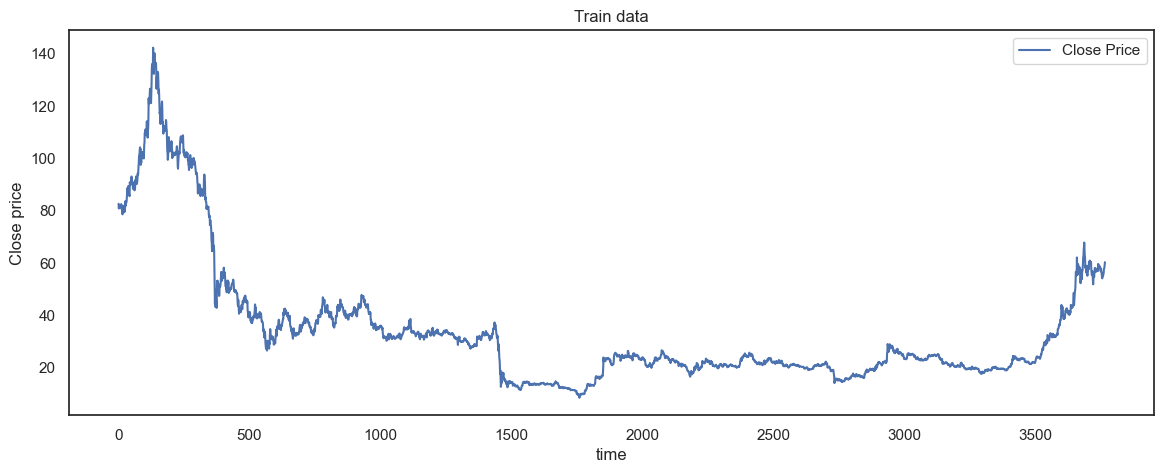

In [18]:
pl.plot_single_col(train_y,len(train_y),"time","Close Price","Close price","Train data")

#### MinMax Scalling

In [19]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

dump(x_scaler, min_max_scaler)

['scalar/min_max_scalar.pkl']

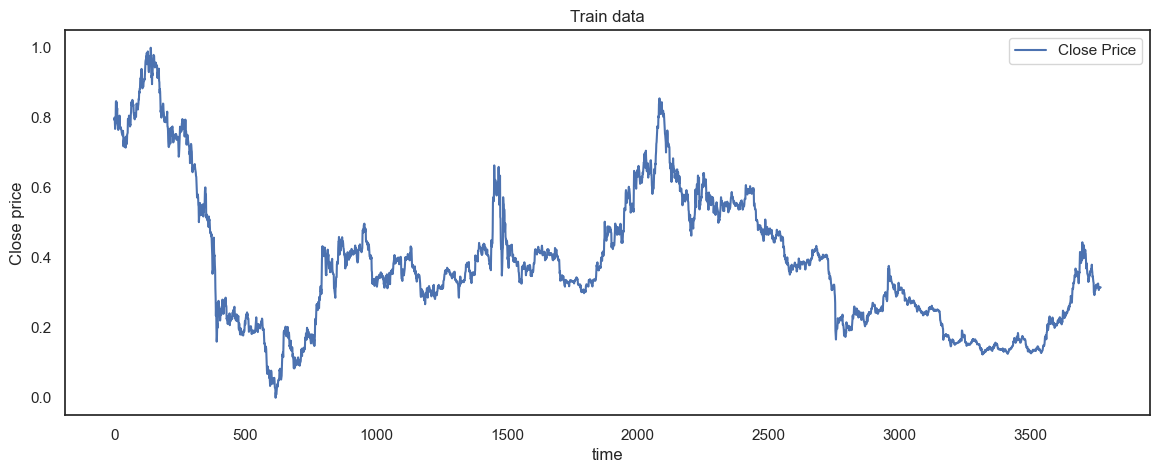

In [28]:
pl.plot_single_col(train_y,len(train_y),"time","Close Price","Close price","Train data")

In [29]:
train_x.shape

(3768, 42)

#### Implement Variational AutoEncorder

In [30]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

#### Create dataset for VAE

In [34]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
# Create dataset = (53,128,41) : num of batches, batch size, features
# 53 = 6700/128 
model = VAE([features, 400, 400, 400, 10], 10)

#### Train the model

[1/300] Loss: 915.3661661148071
[2/300] Loss: 819.3801765441895
[3/300] Loss: 791.8533582687378
[4/300] Loss: 773.5776357650757
[5/300] Loss: 749.7391214370728
[6/300] Loss: 717.6692094802856
[7/300] Loss: 697.1633348464966
[8/300] Loss: 691.2767152786255
[9/300] Loss: 652.7954044342041
[10/300] Loss: 633.6378469467163
[11/300] Loss: 624.2252035140991
[12/300] Loss: 599.2533349990845
[13/300] Loss: 583.591757774353
[14/300] Loss: 567.1337289810181
[15/300] Loss: 530.7668991088867
[16/300] Loss: 521.3074808120728
[17/300] Loss: 517.6948385238647
[18/300] Loss: 495.3426070213318
[19/300] Loss: 467.59806728363037
[20/300] Loss: 463.2328133583069
[21/300] Loss: 453.38624143600464
[22/300] Loss: 416.17570543289185
[23/300] Loss: 400.31843519210815
[24/300] Loss: 398.2668128013611
[25/300] Loss: 388.1071901321411
[26/300] Loss: 365.9230446815491
[27/300] Loss: 341.5639109611511
[28/300] Loss: 332.7596483230591
[29/300] Loss: 340.4830141067505
[30/300] Loss: 327.55888986587524
[31/300] Loss: 

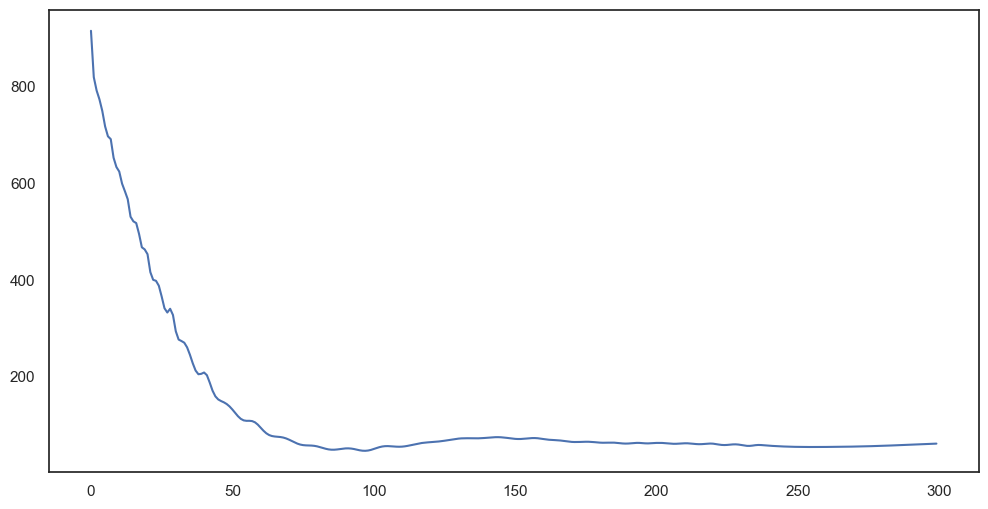

In [35]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")


num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

#### Take output

In [36]:
torch.save(model.state_dict(), vae_model_path)

In [37]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))
print(train_x_mu.shape)
print(test_x_mu.shape)

torch.Size([3768, 10])
torch.Size([943, 10])


In [38]:
df_tr = pd.DataFrame(VAE_train_x.cpu().detach().numpy(), columns=['enc1', 'enc2', 'enc3','enc4', 'enc5', 'enc6','enc7', 'enc8', 'enc9','enc10'])
df_ts = pd.DataFrame(VAE_test_x.cpu().detach().numpy(), columns=['enc1', 'enc2', 'enc3','enc4', 'enc5', 'enc6','enc7', 'enc8', 'enc9','enc10'])
df_ts.index += df_tr.shape[0]

In [39]:
df_vae = pd.concat([df_tr, df_ts], axis=0)
df_vae

,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10
0,-0.460797,-0.729881,0.357198,0.263202,-2.187624,-0.547012,0.477174,-0.164430,-0.800366,2.047071
1,0.385605,0.416905,-0.834451,-0.707463,-1.847446,-0.185619,1.621477,-0.098955,-1.033234,0.022616
2,0.296912,-1.334040,-0.633702,1.697099,-0.923634,-1.735622,-0.259187,2.342708,1.449175,-0.874678
3,0.877815,-1.928901,0.010378,0.566452,2.332200,-0.551581,-0.084605,1.801854,-0.865503,-0.438815
4,-0.522213,-1.730816,-0.083733,-2.296485,0.297081,0.230997,0.505257,-0.832937,0.403288,0.351693
...,...,...,...,...,...,...,...,...,...,...
4706,0.369113,-0.441350,0.563935,1.115576,1.707181,0.217195,0.221154,0.419766,0.297882,1.115555
4707,0.249428,0.701867,0.032636,-1.666326,0.659094,-0.895732,0.371521,0.684959,-1.705076,-0.492606
4708,-2.031955,0.988049,1.061800,1.120337,0.902535,-0.734109,1.051999,0.421776,1.624328,-0.056759
4709,-0.966012,-0.794126,-0.605261,3.336076,-0.778738,0.159407,1.003749,-0.115178,1.393694,0.288515


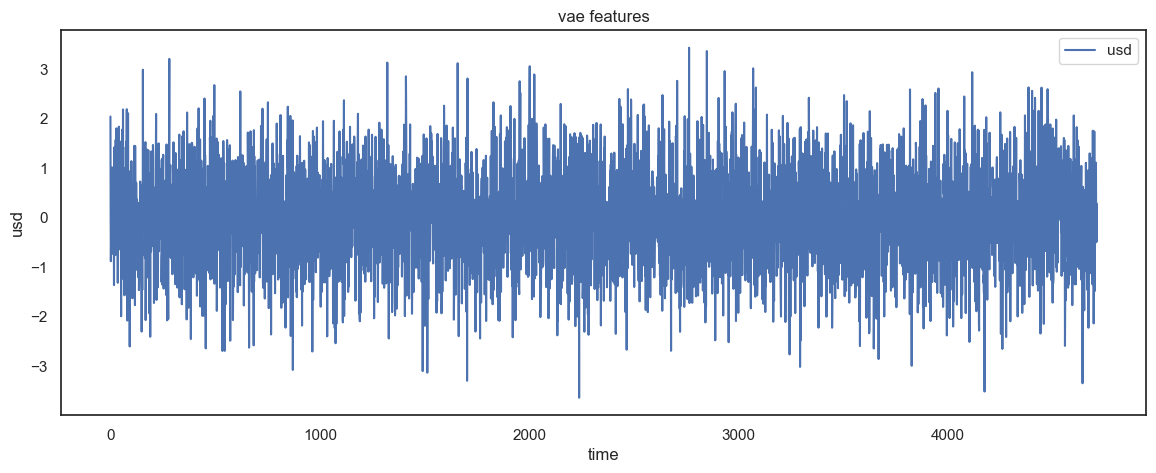

In [40]:
pl.plot_single_col(df_vae["enc10"],df_vae.shape[0],"time","usd","usd","vae features")

In [41]:
df_idc_fft = pd.concat([df_idc_fft, df_vae], axis=1)
print(df_idc_fft.columns)
df_idc_fft

,closet_time,open,close,high,low,volume,no_of_trades,quote_taker_ast_vol,buy_base_ast_vol,taker_buy_quote_ast_vol,...,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10
0,2022-03-08 04:44:59.999,1.42700000,1.45400000,1.46800000,1.45600000,10012611.80000000,23827,14466082.20720000,5090338.70000000,7354011.72800000,...,-0.460797,-0.729881,0.357198,0.263202,-2.187624,-0.547012,0.477174,-0.164430,-0.800366,2.047071
1,2022-03-08 08:44:59.999,1.45500000,1.46300000,1.47100000,1.45900000,10633789.60000000,25611,15344624.53800000,5626745.50000000,8122978.05960000,...,0.385605,0.416905,-0.834451,-0.707463,-1.847446,-0.185619,1.621477,-0.098955,-1.033234,0.022616
2,2022-03-08 12:44:59.999,1.46400000,1.44800000,1.46800000,1.45900000,10771410.80000000,21518,15710850.56250000,5361394.90000000,7820777.64560000,...,0.296912,-1.334040,-0.633702,1.697099,-0.923634,-1.735622,-0.259187,2.342708,1.449175,-0.874678
3,2022-03-08 16:44:59.999,1.44700000,1.41700000,1.46700000,1.45400000,15806691.40000000,38246,22848216.72950000,7801441.90000000,11283950.38300000,...,0.877815,-1.928901,0.010378,0.566452,2.332200,-0.551581,-0.084605,1.801854,-0.865503,-0.438815
4,2022-03-08 20:44:59.999,1.41700000,1.43600000,1.47500000,1.46000000,13571350.10000000,35797,19715369.43920000,7017348.70000000,10196647.36280000,...,-0.522213,-1.730816,-0.083733,-2.296485,0.297081,0.230997,0.505257,-0.832937,0.403288,0.351693


In [44]:
dtl.NaNCheck(df_idc_fft)

Series([], dtype: int64)

Save Processed dataframe with all added features

# PCA

In [16]:
df_pca=df_idc_fft.drop(['closet_time'], axis=1)

In [17]:
df_pca.columns

Index(['open', 'close', 'high', 'low', 'volume', 'no_of_trades',
       'quote_taker_ast_vol', 'buy_base_ast_vol', 'taker_buy_quote_ast_vol',
       'pct_change', 'log_change', 'prev_close', 'SMA3', 'SMA12', 'SMA20',
       'SMA48', 'SMA50', 'SMA288', 'EMA12', 'EMA20', 'EMA26', 'MACD12',
       'MACD24', 'RSI12', 'RSI24', 'RSI36', 'ATR12', 'ATR24', 'ATR36',
       'Upperband12', 'Lowerband12', 'Upperband24', 'Lowerband24',
       'Upperband36', 'Lowerband36', 'MOM10', 'OBV', 'FT_3components',
       'FT_6components', 'FT_9components', 'FT_27components',
       'FT_81components', 'FT_100components'],
      dtype='object')

Standardizing the data

In [18]:
X = df_pca.values # matrix of dataframe 
sc = StandardScaler() 
X_std = sc.fit_transform(X) # standardizing the data
dump(sc, standard_scaler)

['../scalar/standard_scalar_ethusdt.pkl']

### Apply PCA

In [19]:
pca = PCA()
X_pca = pca.fit_transform(X_std) # fit and reduce dimensions
print(pca.n_components_)

43


Determine the number of components

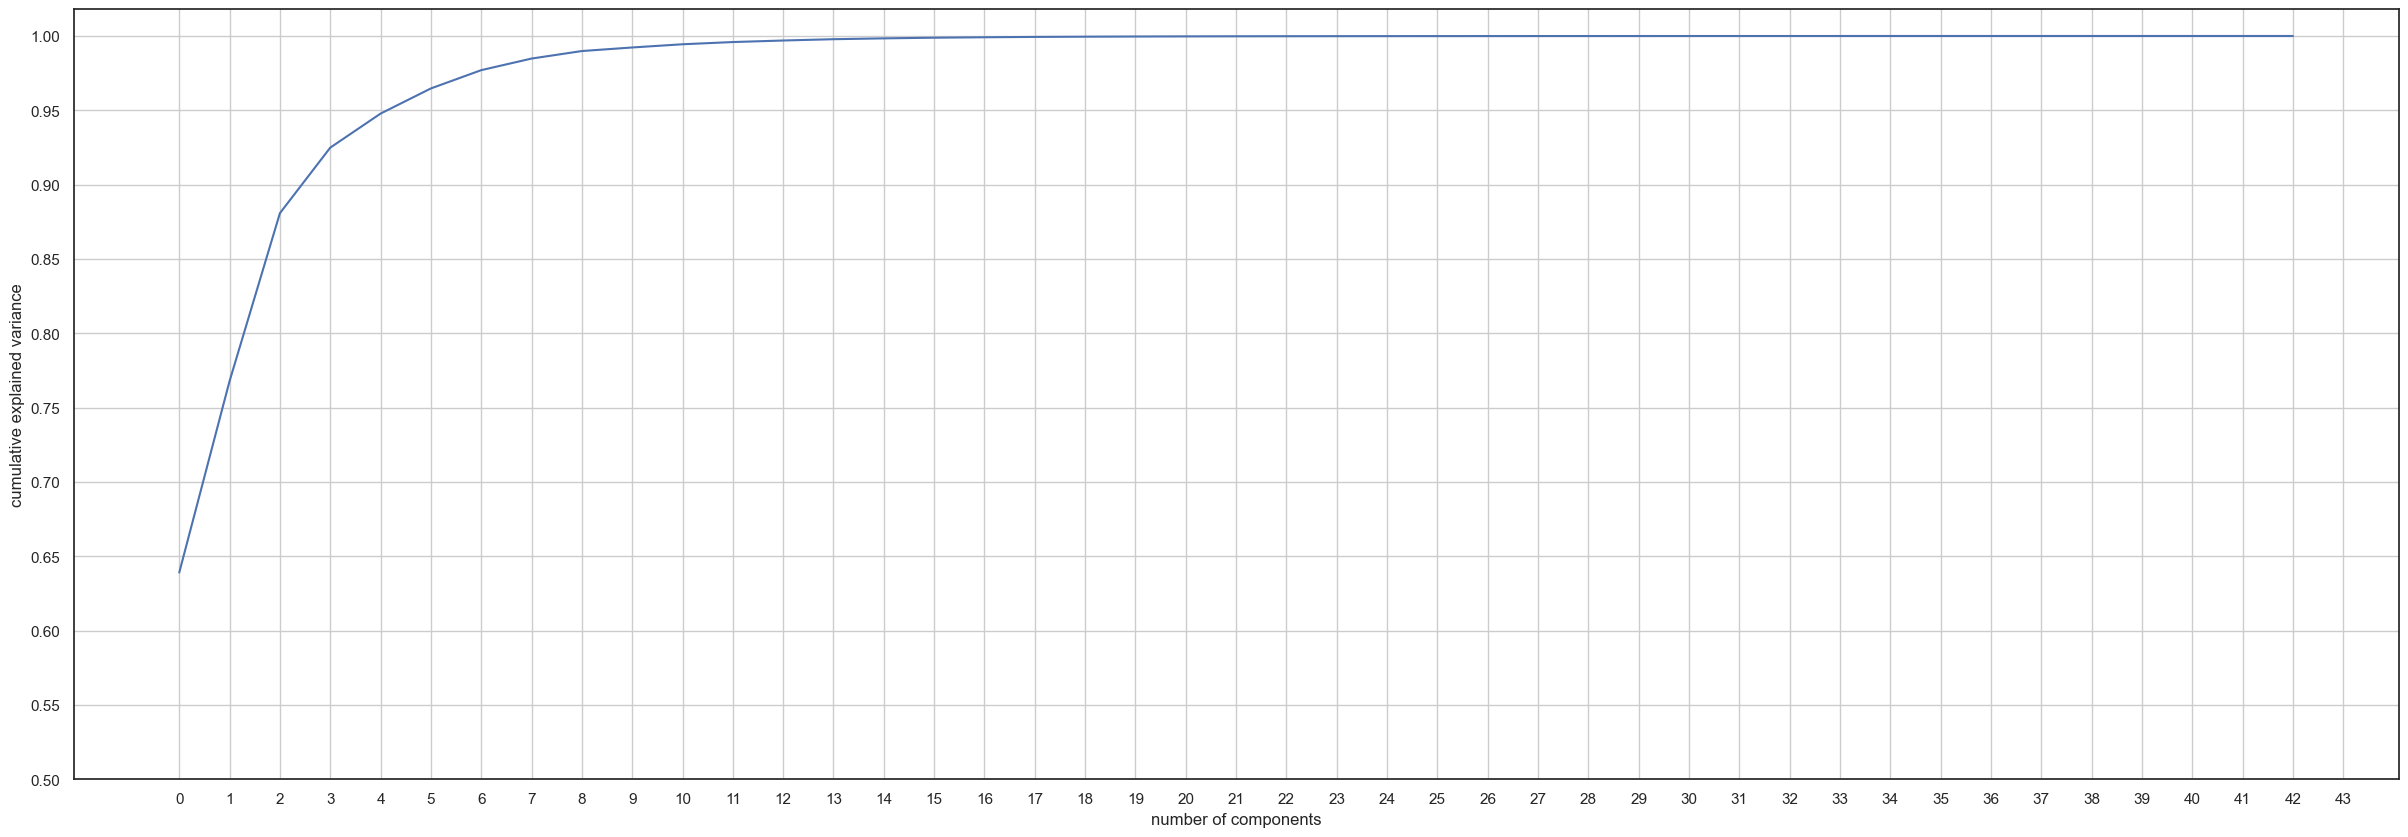

In [20]:
plt.figure(figsize=(30, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, df_pca.shape[1]+1, 1.0))
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

Dimensionality Reduction

In [21]:
num_components = 17
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std) # fit and reduce dimension

In [22]:
print(df_pca.shape)
print(X_pca.shape)

(4711, 43)
(4711, 17)


Finding the most important features set

In [23]:
n_pcs= pca.n_components_ # get number of component

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = df_pca.columns

# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
for i in most_important_names:
  print(i,end="\n")

Upperband12
MACD12
buy_base_ast_vol
pct_change
ATR36
OBV
MOM10
MACD24
FT_3components
buy_base_ast_vol
no_of_trades
no_of_trades
ATR12
ATR12
FT_3components
MACD12
FT_9components


In [24]:
df_PCA=X_pca.copy()
# ,"pca18","pca19","pca20","pca21","pca22","pca23"
df_PCA = pd.DataFrame(df_PCA,columns=["pca1","pca2","pca3","pca4","pca5","pca6","pca7","pca8","pca9","pca10","pca11","pca12","pca13","pca14","pca15","pca16","pca17"])
df_PCA["close"] = df_idc_fft["close"]
df_PCA

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,close
0,6.019437,-0.069303,-1.907798,0.511334,-2.286440,-0.593792,0.205505,-0.574960,-1.151631,-0.180282,-1.159124,0.118756,0.234595,-0.506285,-0.318508,0.104309,-0.032977,2583.87000000
1,5.976650,0.303710,-1.870899,0.270843,-2.035799,-0.685556,0.210575,-0.577620,-1.217314,-0.242867,-1.109281,0.112663,0.242677,-0.548263,-0.330359,0.039792,-0.063716,2573.98000000
2,6.093353,0.570390,-0.600548,0.894818,-1.752256,-0.657627,0.966708,-0.421873,-0.991752,-0.162797,-1.090720,-0.364563,0.216714,-0.714944,-0.432576,0.229119,-0.010957,2582.86000000
3,5.891333,-0.431049,-2.009123,0.850143,-2.166427,-0.694796,0.224582,-0.583134,-1.222211,-0.183625,-1.128346,0.197705,0.225219,-0.500266,-0.297664,0.045247,-0.070994,2588.71000000
4,5.922183,-0.000431,-1.553510,0.617569,-1.816441,-0.807563,0.379904,-0.610715,-1.244595,-0.272932,-1.043921,0.154211,0.230431,-0.584474,-0.309399,0.006234,-0.105978,2590.42000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,8.711835,-2.248315,-0.655791,0.272203,-0.671798,1.906057,0.971472,-0.038326,-0.530942,0.335971,0.334355,0.107667,-0.164766,0.180125,-0.218085,-0.014961,-0.409842,3133.16000000
4707,8.630016,-1.426997,-1.217513,-1.086985,-0.617194,1.881874,1.091309,-0.000220,-0.530787,0.382486,0.270519,-0.078601,-0.207596,0.124419,-0.282552,0.032203,-0.366323,3094.93000000
4708,8.596329,-1.167663,-1.040498,-0.024208,-0.157936,1.630981,0.640826,0.098957,-0.718534,0.179932,0.315789,0.054630,-0.229827,0.142280,-0.256688,-0.034159,-0.394245,3091.41000000
4709,8.725520,-1.905287,-0.207511,1.694338,-0.036989,1.500275,0.349429,0.068325,-0.821517,0.131901,0.512353,0.061789,-0.117686,0.100043,-0.245006,-0.031114,-0.431805,3146.38000000


# Feature Selection

In [25]:
df=df_PCA.copy()
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

In [26]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 4711 samples, and 18 features.


In [27]:
labels_df = df["close"]
features_df = df.drop(columns=["close"])

### XGBOOST

In [88]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['close']
    X = data.drop(columns=["close"])
    
    train_samples = int(X.shape[0] * 0.99)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [89]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df)

In [90]:
X_train_FI.columns

Index(['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9',
       'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16', 'pca17'],
      dtype='object')

In [91]:
print("Shape of x_train : ",X_train_FI.shape[0],",", X_train_FI.shape[1])
print("Shape of x_test : ",X_test_FI.shape[0],",", X_test_FI.shape[1])

Shape of x_train :  4663 , 17
Shape of x_test :  48 , 17


In [92]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [93]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [94]:
eval_result = regressor.evals_result()
eval_result

{'validation_0': OrderedDict([('rmse',
               [0.2976449405917724,
                0.28300298858691497,
                0.26908924911911697,
                0.25586628599197747,
                0.24329761077281206,
                0.2313469751562745,
                0.22000199116658734,
                0.2092179539211116,
                0.1989678999976988,
                0.18922212609638678,
                0.17996036713015687,
                0.1711660972817003,
                0.1628073420063629,
                0.15486050050757233,
                0.14730940678623508,
                0.1401402721520123,
                0.13332370711742866,
                0.1268475143380804,
                0.12069077510508784,
                0.11483714053844445,
                0.10927944435142871,
                0.10400062956398834,
                0.09898012309676442,
                0.09420957072913677,
                0.0896780095686243,
                0.08536646414599716,
        

In [95]:
training_rounds = range(len(eval_result['validation_0']['rmse']))
training_rounds

range(0, 150)

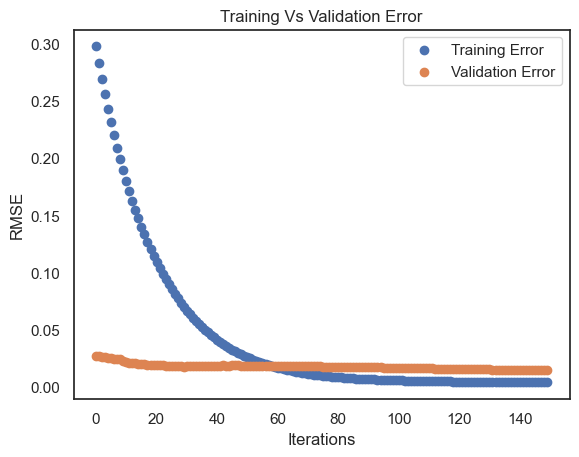

In [96]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

#### Check Feature importance

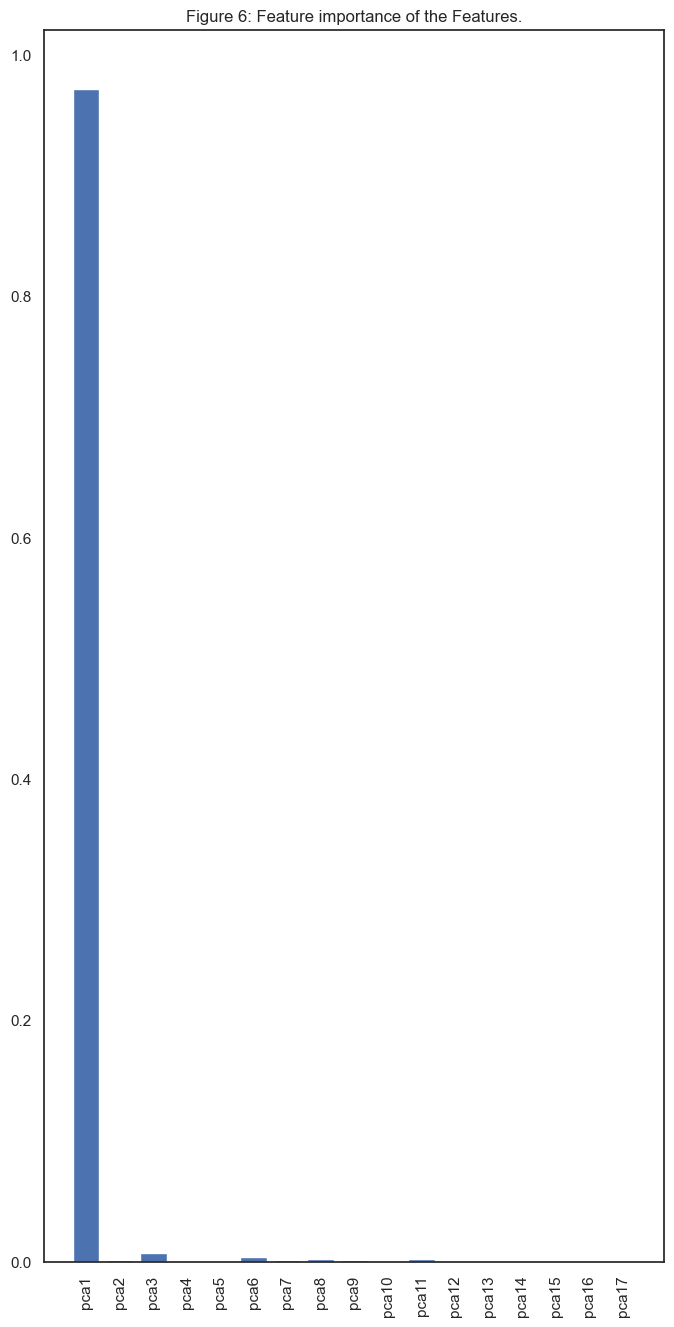

In [97]:
fig = plt.figure(figsize=(8,16))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the Features.')
plt.show()

weight: The number of times a feature is used to split the data across all trees.

gain: The average gain of the feature when it is used in a tree.

cover: The average coverage of the feature when it is used in a tree (coverage is defined as the number of samples affected by the split).

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

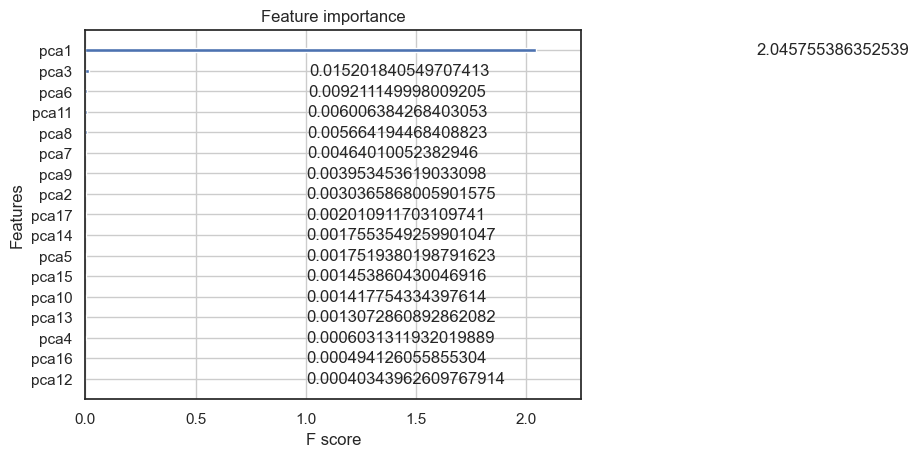

In [98]:
xgb.plot_importance(xgbModel, importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

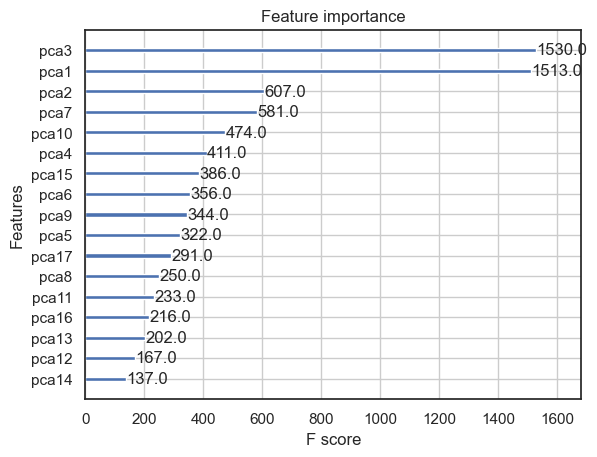

In [99]:
xgb.plot_importance(xgbModel, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

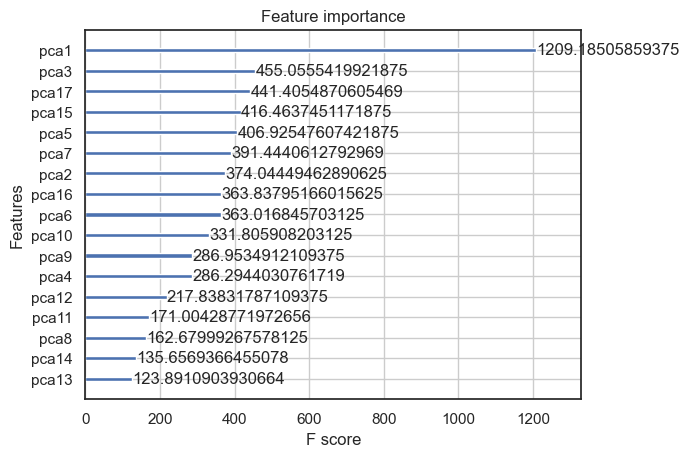

In [100]:
xgb.plot_importance(xgbModel, importance_type='cover')

In [101]:
df = df.drop(columns=["pca8","pca10","pca12","pca15"])
df_PCA = df
df_PCA.shape

### MI-Score

In [71]:
# labels_df = labels_df.iloc[:20000].values.reshape((20000,1))
# features_df = features_df.iloc[:20000]

In [72]:
# features_df

In [73]:
# features_df.shape

In [74]:
# labels_df.shape

In [75]:
# def make_mi_scores(X, y, discrete_features):
#     mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores


# discrete_features=features_df.dtypes == float
# mi_scores = make_mi_scores(features_df,labels_df,discrete_features)

# def plot_mi_scores(scores):
#     scores = scores.sort_values(ascending=True)
#     width = np.arange(len(scores))
#     ticks = list(scores.index)
#     plt.barh(width, scores)
#     plt.yticks(width, ticks)
#     plt.title("Mutual Information Scores")


# plt.figure(dpi=100, figsize=(8, 5))
# plot_mi_scores(mi_scores)

### Identifying Feature Correlation 

<Axes: >

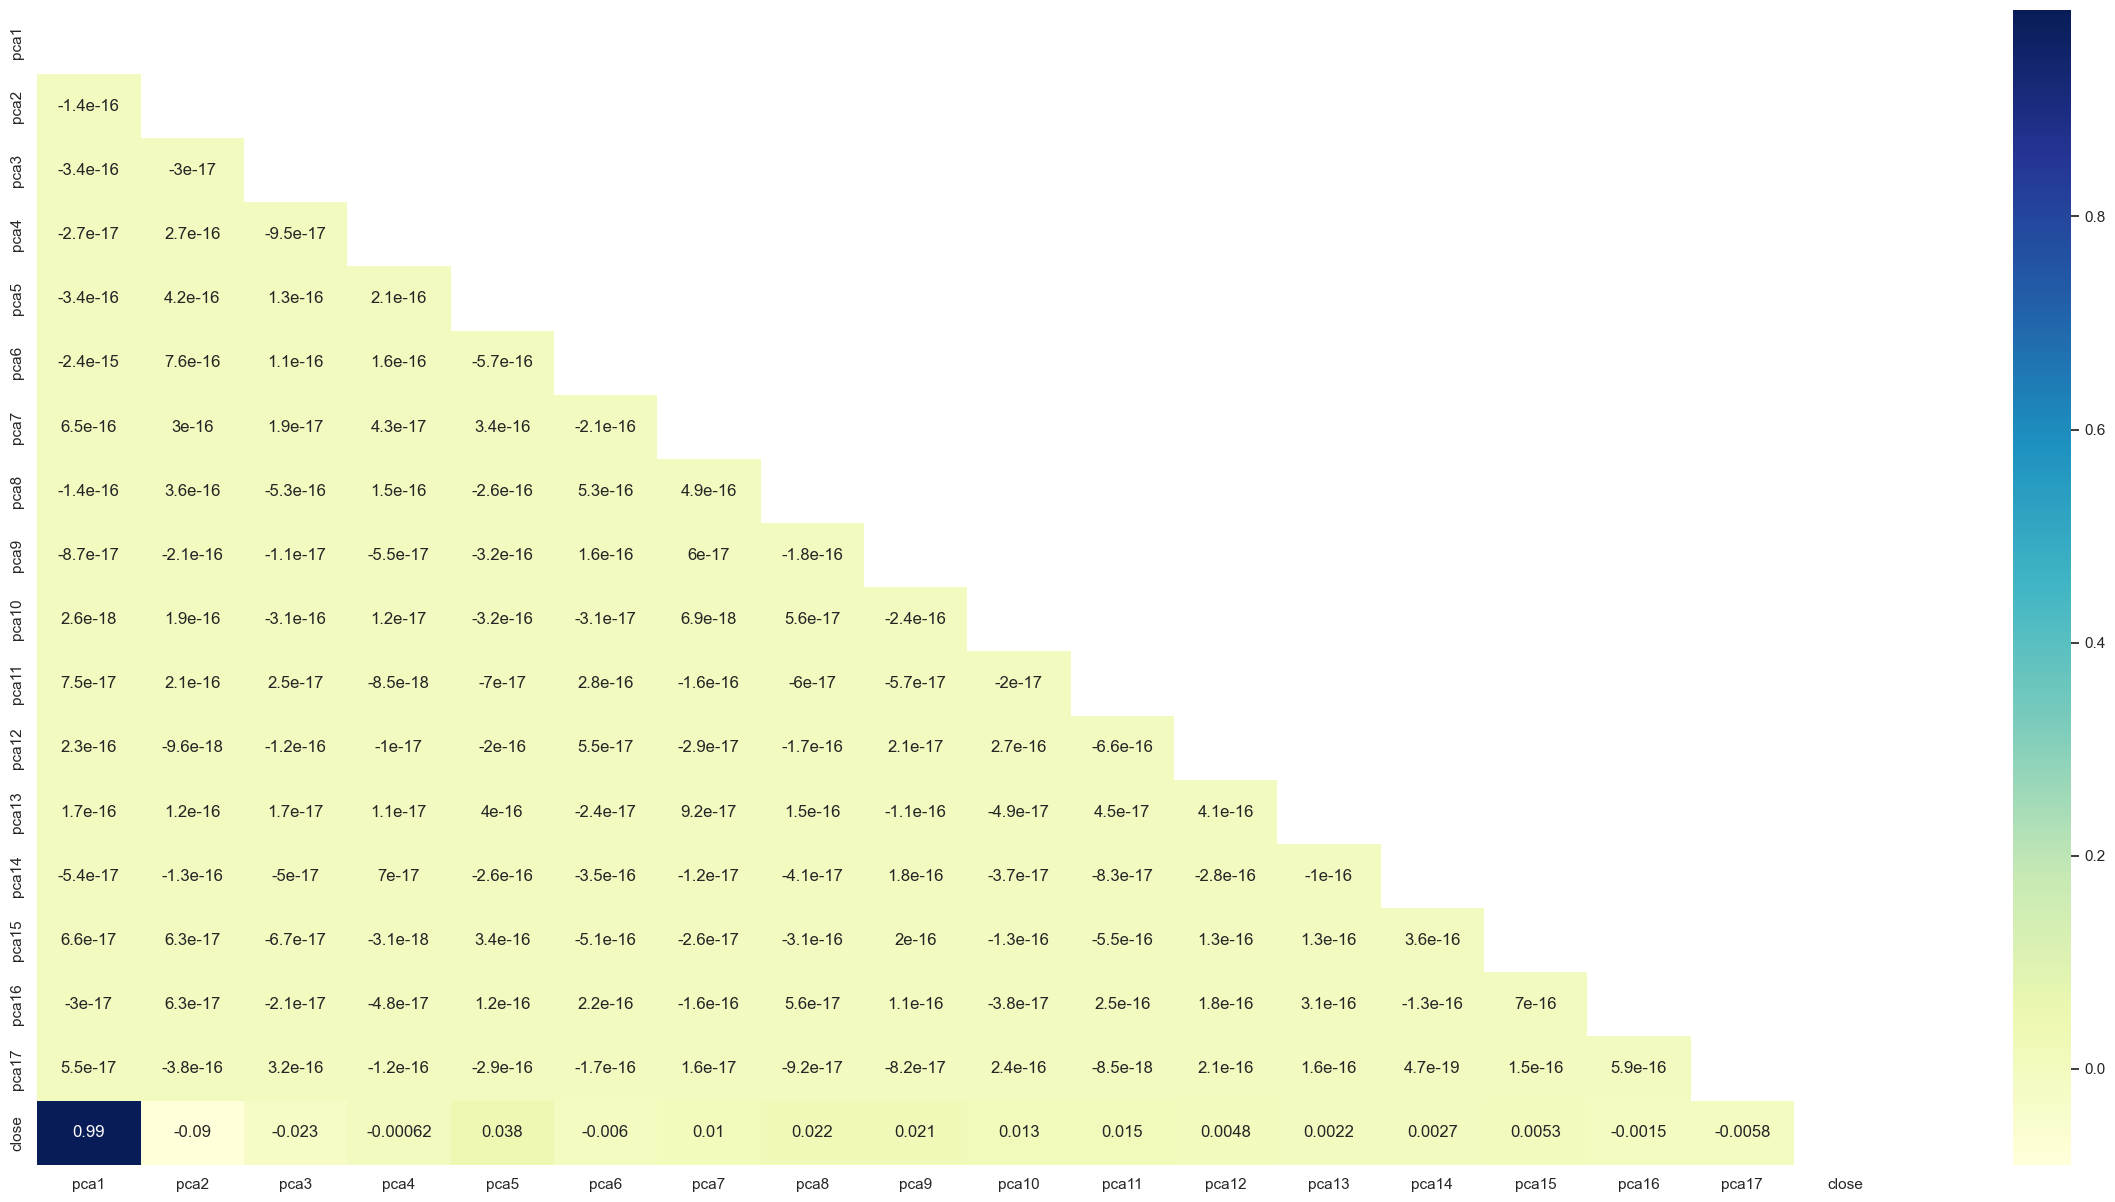

In [28]:
corr=df_PCA.corr()
matrix = np.triu(corr)

plt.figure(figsize=[30,15])
sns.heatmap(corr, annot=True, mask=matrix,cmap="YlGnBu")

In [29]:
df_PCA.isnull().sum()[df_PCA.isnull().sum()>0]

Series([], dtype: int64)

## Save CSV

In [30]:
df_PCA

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,close
0,6.019437,-0.069303,-1.907798,0.511334,-2.286440,-0.593792,0.205505,-0.574960,-1.151631,-0.180282,-1.159124,0.118756,0.234595,-0.506285,-0.318508,0.104309,-0.032977,2583.87000000
1,5.976650,0.303710,-1.870899,0.270843,-2.035799,-0.685556,0.210575,-0.577620,-1.217314,-0.242867,-1.109281,0.112663,0.242677,-0.548263,-0.330359,0.039792,-0.063716,2573.98000000
2,6.093353,0.570390,-0.600548,0.894818,-1.752256,-0.657627,0.966708,-0.421873,-0.991752,-0.162797,-1.090720,-0.364563,0.216714,-0.714944,-0.432576,0.229119,-0.010957,2582.86000000
3,5.891333,-0.431049,-2.009123,0.850143,-2.166427,-0.694796,0.224582,-0.583134,-1.222211,-0.183625,-1.128346,0.197705,0.225219,-0.500266,-0.297664,0.045247,-0.070994,2588.71000000
4,5.922183,-0.000431,-1.553510,0.617569,-1.816441,-0.807563,0.379904,-0.610715,-1.244595,-0.272932,-1.043921,0.154211,0.230431,-0.584474,-0.309399,0.006234,-0.105978,2590.42000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,8.711835,-2.248315,-0.655791,0.272203,-0.671798,1.906057,0.971472,-0.038326,-0.530942,0.335971,0.334355,0.107667,-0.164766,0.180125,-0.218085,-0.014961,-0.409842,3133.16000000
4707,8.630016,-1.426997,-1.217513,-1.086985,-0.617194,1.881874,1.091309,-0.000220,-0.530787,0.382486,0.270519,-0.078601,-0.207596,0.124419,-0.282552,0.032203,-0.366323,3094.93000000
4708,8.596329,-1.167663,-1.040498,-0.024208,-0.157936,1.630981,0.640826,0.098957,-0.718534,0.179932,0.315789,0.054630,-0.229827,0.142280,-0.256688,-0.034159,-0.394245,3091.41000000
4709,8.725520,-1.905287,-0.207511,1.694338,-0.036989,1.500275,0.349429,0.068325,-0.821517,0.131901,0.512353,0.061789,-0.117686,0.100043,-0.245006,-0.031114,-0.431805,3146.38000000


In [31]:
df_PCA.to_csv(pre_processed, index=False)